In [1]:
import torch
from PIL import Image
import numpy as np
import time
import os

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

import torchvision
from torchvision.models.detection import (
    ssdlite320_mobilenet_v3_large,
    SSDLite320_MobileNet_V3_Large_Weights,
    ssd300_vgg16,
    SSD300_VGG16_Weights
)
from torchvision.transforms import v2
from torchvision.ops import box_iou, box_convert
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import StepLR

import pathlib
from pathlib import Path

from typing import Tuple

import CarImageClass

from SSD_from_scratch import mySSD
from SSD_trainer import SSD_train_step, SSD_test_step, SSD_train, plot_losses, collate_detection, ConditionalIoUCrop

device = "cuda" if torch.cuda.is_available() else "cpu"

# desktop or laptop
machine = 'desktop'

# Setup path to data folder
if machine == 'laptop':
    folder_path = Path(r"C:\self-driving-car\data")
else:
    folder_path = Path(r"D:\Udacity_car_data\data")

train_path = folder_path / "train"
test_path = folder_path / "test"
train_path_simple = folder_path / "train_simple"
test_path_simple = folder_path / "test_simple"
train_path_oo = folder_path / "train_one_obj"
test_path_oo = folder_path / "test_one_obj"

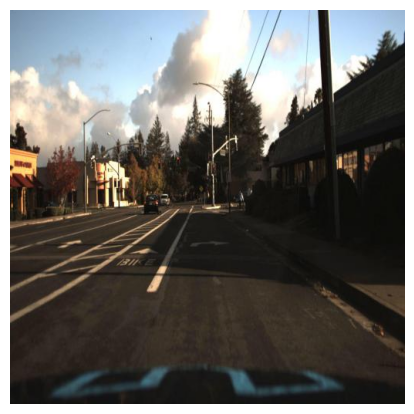

In [2]:
# transforms
train_tfms = v2.Compose([
    #v2.ToImage(),                                 # uint8 -> Tensor[C,H,W]
    #v2.ToDtype(torch.float32, scale=True),        # to float in [0,1]
    #v2.RandomHorizontalFlip(p=0.5),
    #v2.RandomPhotometricDistort(p=0.5),
    v2.Resize((300, 300)),                        # pick a fixed size for batching
    #v2.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225]),
])

train_data = CarImageClass.ImageClass(targ_dir=train_path, transform=None, file_pct=1)

train_data.show_with_box(index=53, color='r', label=False, lw=0)

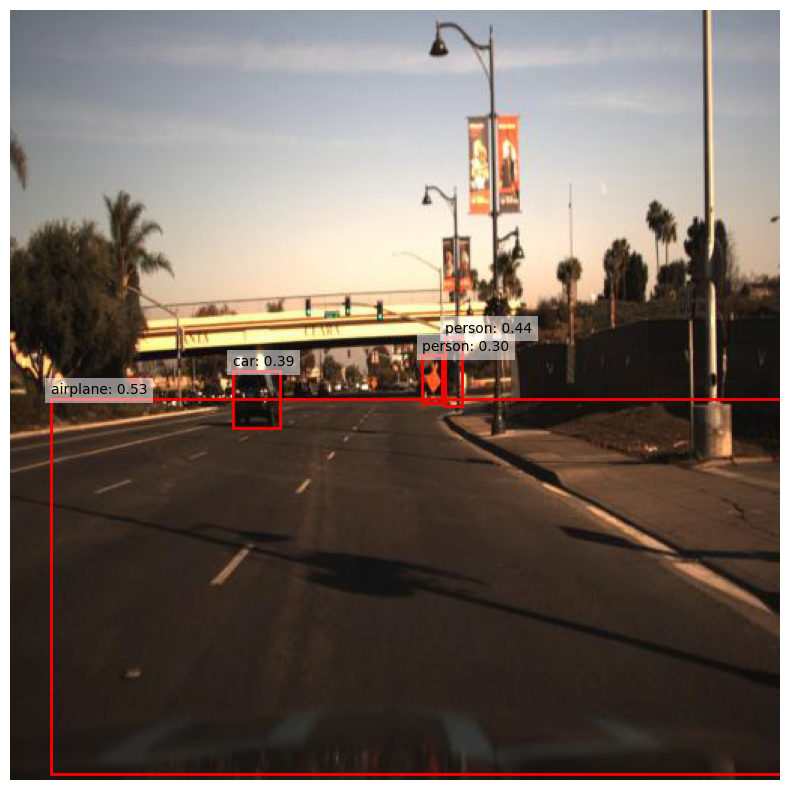

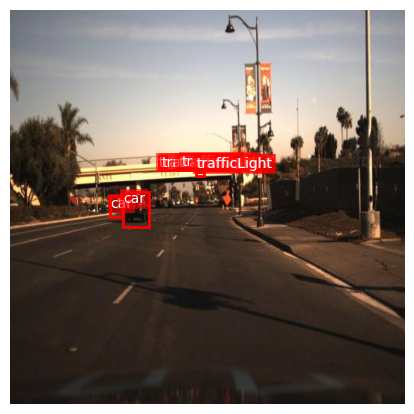

In [10]:
# 1) Device and weights
# device = torch.device("cpu")   # or "cuda" if available
weights = SSD300_VGG16_Weights.DEFAULT
categories = weights.meta["categories"]  # list of class names

# 2) Model
model = ssd300_vgg16(weights=weights).to(device).eval()

# 3) Load image
rand_idx = np.random.randint(0, len(train_data), size=1)[0]
img = train_data.load_image(rand_idx)
# img_path = np.random.choice(all_paths, size=1)[0] # r"C:\self-driving-car\data\train_one_obj\1478019978686299906_jpg.rf.bxnJeeEptGCrdAcL9zPM.jpg" #"your_image.jpg"
# img = Image.open(img_path).convert("RGB")          # keep original for plotting

# 4) Preprocess
preprocess = weights.transforms()
img_t = preprocess(img)                            # Tensor [C, 300, 300]
batch = img_t.unsqueeze(0).to(device)              # [1, C, H, W]

# 5) Inference
with torch.no_grad():
    out = model(batch)[0]                          # dict with 'boxes','labels','scores'

# 6) Pull results to CPU numpy
boxes  = out["boxes"].cpu().numpy()                # shape [N,4], xyxy in *resized* coords
labels = out["labels"].cpu().numpy()               # shape [N]
scores = out["scores"].cpu().numpy()               # shape [N]

# 7) Confidence filtering
thr = 0.25
keep = scores >= thr
boxes, labels, scores = boxes[keep], labels[keep], scores[keep]
names = [categories[i] for i in labels]

# 8) (Optional) Map boxes back to original image size
H_resized, W_resized = img_t.shape[1], img_t.shape[2]  # 300, 300
H_orig,    W_orig    = 512, 512 #img.height, img.width
sx = W_orig / W_resized
sy = H_orig / H_resized
boxes_orig = boxes.copy()
boxes_orig[:, [0,2]] *= sx
boxes_orig[:, [1,3]] *= sy

# 9) (Optional) Visualize
def draw(img_pil, boxes_xyxy, labels_txt, scores_arr):
    fig, ax = plt.subplots(figsize=(10, 10))
    ax.imshow(img_pil)
    for (x1, y1, x2, y2), lbl, sc in zip(boxes_xyxy, labels_txt, scores_arr):
        ax.add_patch(plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                   fill=False, linewidth=2, edgecolor='r'))
        ax.text(x1, y1-3, f"{lbl}: {sc:.2f}", fontsize=10,
                bbox=dict(facecolor="white", alpha=0.5, edgecolor="none"))
    ax.axis("off")
    plt.show()

draw(img, boxes_orig, names, scores)

train_data.show_with_box(index=rand_idx, color='r', label=True)

  0%|          | 0/20 [00:00<?, ?it/s]

Epoch: 0  |  Train loc loss: 5.4486  |  Train class loss: 9.1194  |  Test loc loss: 4.0156  |  Test class loss: 3.1584
Epoch: 1  |  Train loc loss: 4.6828  |  Train class loss: 3.4625  |  Test loc loss: 3.7285  |  Test class loss: 3.0469
Epoch: 2  |  Train loc loss: 4.4678  |  Train class loss: 3.6631  |  Test loc loss: 3.6914  |  Test class loss: 2.9720
Epoch: 3  |  Train loc loss: 4.6361  |  Train class loss: 3.7176  |  Test loc loss: 3.7707  |  Test class loss: 3.0623
Epoch: 4  |  Train loc loss: 4.1390  |  Train class loss: 3.1624  |  Test loc loss: 3.6569  |  Test class loss: 2.9594
Epoch: 5  |  Train loc loss: 4.0368  |  Train class loss: 3.6810  |  Test loc loss: 4.7037  |  Test class loss: 3.0160
Epoch: 6  |  Train loc loss: 4.0836  |  Train class loss: 3.5865  |  Test loc loss: 3.5502  |  Test class loss: 2.9028
Epoch: 7  |  Train loc loss: 3.8416  |  Train class loss: 3.2016  |  Test loc loss: 3.4709  |  Test class loss: 2.9830
Epoch: 8  |  Train loc loss: 3.8030  |  Train cl

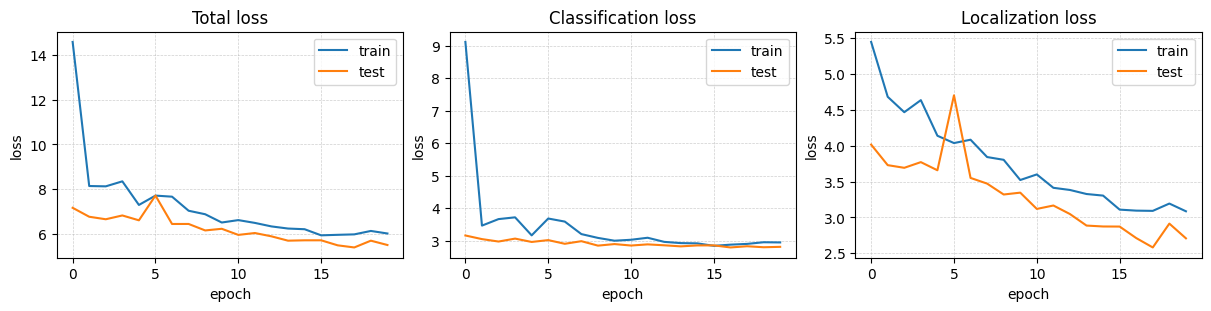

In [9]:
ssdtestmodel = mySSD(num_classes=6).to(device)
optimizer = torch.optim.SGD(ssdtestmodel.parameters(), lr=1e-2, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.8)

# transforms
train_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomZoomOut(fill=0, p=0.5),

    ConditionalIoUCrop(
        min_area_frac=0.02,
        min_scale=0.6, max_scale=1.0,
        min_aspect_ratio=0.75, max_aspect_ratio=1.33,
        sampler_options=[0.05, 0.1, 0.3],
        trials=3
    ),

    v2.SanitizeBoundingBoxes(min_size=1.0),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPhotometricDistort(p=0.5),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])

train_set = CarImageClass.ImageClass(targ_dir=train_path, transform=train_tfms, file_pct=0.02)
# test_data = CarImageClass.ImageClass(targ_dir=test_path, transform=test_tfms, file_pct=0.01)

train_data, val_data = CarImageClass.make_train_test_split(full_set=train_set, test_size=0.25, transform_train=train_tfms, transform_test=test_tfms)


if os.name == "nt":
    torch.multiprocessing.set_start_method("spawn", force=True)
    
BATCH_SIZE = 8
NUM_WORKERS = 8
# Create DataLoader's
train_dataloader = DataLoader(train_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                              num_workers=NUM_WORKERS,
                              persistent_workers=True,
                              prefetch_factor=1,
                              collate_fn=collate_detection
                              )

val_dataloader = DataLoader(val_data, 
                             batch_size=BATCH_SIZE, 
                             shuffle=False, 
                             num_workers=NUM_WORKERS,
                             persistent_workers=True,
                             prefetch_factor=1,
                             collate_fn=collate_detection
                             )

results = SSD_train(model=ssdtestmodel,
                    train_dataloader=train_dataloader,
                    test_dataloader=val_dataloader,
                    optimizer=optimizer,
                    priors_cxcywh=ssdtestmodel.priors,
                    device=device,
                    early_stopping_rounds=None,
                    epochs=20)

plot_losses(results)

In [25]:
torch.save(ssdtestmodel.state_dict(), r"C:\Users\eblac\Documents\GitHub\self-driving-car\saved_models\test_model_1.pth")

In [77]:
model_load_test = mySSD(num_classes=6)
model_load_test.load_state_dict(torch.load(r"C:\Users\eblac\Documents\GitHub\self-driving-car\saved_models\test_model_1.pth", map_location='cpu', weights_only=False))
model_load_test.to(device)

img0, _ = train_data[0]                 # runs transforms once
x = img0.unsqueeze(0).to(device)        # cache the exact tensor

test1_output = ssdtestmodel.predict(x)
loaded_output = model_load_test.predict(x)

test1_output[0]['scores'] == loaded_output[0]['scores']

True

In [2]:
ssdtestmodel = mySSD(num_classes=6).to(device)
optimizer = torch.optim.SGD(ssdtestmodel.parameters(), lr=1e-3, momentum=0.9)
scheduler = StepLR(optimizer, step_size=5, gamma=0.5)

# transforms
train_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.RandomZoomOut(fill=0, p=0.5),

    ConditionalIoUCrop(
        min_area_frac=0.02,
        min_scale=0.6, max_scale=1.0,
        min_aspect_ratio=0.75, max_aspect_ratio=1.33,
        sampler_options=[0.05, 0.1, 0.3],
        trials=3
    ),

    v2.SanitizeBoundingBoxes(min_size=1.0),
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomPhotometricDistort(p=0.5),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((300, 300), antialias=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]),
])

train_set = CarImageClass.ImageClass(targ_dir=train_path, transform=train_tfms, file_pct=0.02)
# test_data = CarImageClass.ImageClass(targ_dir=test_path, transform=test_tfms, file_pct=0.01)

train_data, val_data = CarImageClass.make_train_test_split(full_set=train_set, test_size=0.25, transform_train=train_tfms, transform_test=test_tfms)

In [8]:
BATCH_SIZE = 16
NUM_WORKERS = 8

if os.name == "nt":
    torch.multiprocessing.set_start_method("spawn", force=True)

# Create DataLoader's
train_dataloader = DataLoader(train_data, 
                              batch_size=BATCH_SIZE, 
                              shuffle=True, 
                              num_workers=NUM_WORKERS,
                            #   pin_memory=True,
                            #   persistent_workers=True,
                              prefetch_factor=1,
                              collate_fn=collate_detection
                              )

torch.cuda.synchronize()
t0 = time.time()
for batch, (images, targets) in enumerate(train_dataloader):
    torch.cuda.synchronize()
    t_load = time.time()
    images = images.to(device)
    
    # forward pass
    loc_all, conf_all = ssdtestmodel(images)
    N, P, C = conf_all.shape          # N - batch size, P - number of priors (8732), C - number of classes

    # -------- 1) Build per-image targets via encode() --------
    H, W = images.shape[-2], images.shape[-1]     # image size - should be 300x300
    norm = torch.tensor([W, H, W, H], device=device, dtype=torch.float32)

    loc_t_list   = []
    cls_t_list   = []
    pos_mask_lst = []

    for i in range(N):
        # normalize GT to [0,1] and convert to cxcywh
        gt_xyxy_px = targets[i]['boxes'].to(device=device, dtype=torch.float32)
        gt_labels  = targets[i]['labels'].to(device=device)
        if gt_xyxy_px.numel() == 0:
            gt_cxcywh = gt_xyxy_px.new_zeros((0,4))
        else:
            gt_xyxy = gt_xyxy_px / norm
            gt_cxcywh = box_convert(gt_xyxy, in_fmt='xyxy', out_fmt='cxcywh')

        loc_t, cls_t, pos_mask, _ = mySSD.encode_ssd(
            gt_cxcywh, gt_labels, ssdtestmodel.priors,
            iou_thresh=0.5, variances=(0.1, 0.2), background_class=0
        )
        # shapes: [P,4], [P], [P]
        loc_t_list.append(loc_t)
        cls_t_list.append(cls_t)
        pos_mask_lst.append(pos_mask)

    loc_t   = torch.stack(loc_t_list, dim=0).to(device)      # [N,P,4]
    cls_t   = torch.stack(cls_t_list, dim=0).to(device)      # [N,P]
    pos_mask = torch.stack(pos_mask_lst, dim=0).to(device)   # [N,P] bool
    neg_mask = ~pos_mask

    # number of positives per image (avoid zero division)
    num_pos_per_img = pos_mask.sum(dim=1)                    # [N]
    total_pos = num_pos_per_img.sum().clamp_min(1).float()   # scalar


    # -------- 2) Localization loss (positives only) --------
    # SmoothL1 on offsets (no decode), sum then normalize by #pos
    loc_loss_sL1 = torch.nn.functional.smooth_l1_loss(
        loc_all[pos_mask], loc_t[pos_mask], reduction='sum'
    ) / total_pos

    # -------- 3) Classification loss with hard-negative mining --------
    # cross-entropy per prior (no reduction)
    ce = torch.nn.functional.cross_entropy(
        conf_all.view(-1, C), cls_t.view(-1), reduction='none'
    ).view(N, P)  # [N,P]

    # keep CE on positives always
    ce_pos = (ce * pos_mask.float()).sum()

    # select hardest negatives per image at ratio R:1 w.r.t positives
    ce_neg_sum = torch.tensor(0.0, device=device)
    for i in range(N):
        n_pos = int(num_pos_per_img[i].item())
        if n_pos == 0:
            # still allow some negatives to contribute (common trick: pretend 1 positive)
            max_negs = int(3)
        else:
            max_negs = int(3 * n_pos)

        ce_neg_i = ce[i].masked_select(neg_mask[i])         # [#neg_i]
        if ce_neg_i.numel() == 0 or max_negs == 0:
            continue
        k = min(max_negs, ce_neg_i.numel())
        topk_vals, _ = torch.topk(ce_neg_i, k, largest=True, sorted=False)
        ce_neg_sum += topk_vals.sum()

    conf_loss = (ce_pos + ce_neg_sum) / total_pos

    # loss
    batch_loss = loc_loss_sL1 + conf_loss
    
    # loc_loss += loc_loss_sL1.item()
    # cls_loss += conf_loss.item()
    # train_loss += batch_loss.item()

    # Optimizer zero grad
    optimizer.zero_grad(set_to_none=True)

    # loss backward
    batch_loss.backward()

    # optimizer step
    optimizer.step()


    t_step = time.time()
    if batch<15:
        print(f"batch {batch}: load {t_load-t0:.3f}s, step {t_step-t_load:.3f}s")
        t0 = time.time()
    else:
        break

batch 0: load 33.986s, step 0.526s
batch 1: load 0.143s, step 0.267s
batch 2: load 0.438s, step 0.206s
batch 3: load 0.196s, step 0.221s
batch 4: load 4.106s, step 0.413s
batch 5: load 0.203s, step 0.181s
batch 6: load 0.200s, step 0.212s
batch 7: load 0.187s, step 0.196s
batch 8: load 0.189s, step 0.194s
batch 9: load 0.193s, step 0.217s
batch 10: load 0.194s, step 0.208s
batch 11: load 0.191s, step 0.265s
batch 12: load 0.904s, step 0.197s
batch 13: load 0.199s, step 0.218s
batch 14: load 0.186s, step 0.215s


In [10]:
def show_with_box(img_plus_target,
                  color: str = "C0",
                  lw: int = 2,
                  label: bool = False,
                  pred_box: bool = False,
                  bbox_pred: torch.Tensor = torch.zeros((1,4)),
                  label_pred: str = None
                  ):
        
        # convert the image to a numpy array
        img, target = img_plus_target

        if isinstance(img, Image.Image):
            arr = np.array(img)
        elif isinstance(img, np.ndarray):
            arr = img
            if arr.ndim == 3 and arr.shape[0] in (1, 3) and arr.shape[2] not in (1, 3):
                arr = np.transpose(arr, (1, 2, 0))
        elif isinstance(img, torch.Tensor):
            t = img.detach().cpu()
            if t.ndim == 3 and t.shape[0] in (1, 3):  # CHW -> HWC
                t = t.permute(1, 2, 0)
            arr = t.numpy()
        else:
            raise TypeError(f"Unsupported image type: {type(img)}")

        if arr.dtype.kind == "f" and arr.max() <= 1.0:
            arr = (arr * 255.0).clip(0, 255).astype(np.uint8)
        elif arr.dtype != np.uint8:
            arr = arr.astype(np.uint8)
        

        # plot image
        H, W = arr.shape[:2]
        dpi = 100
        fig, ax = plt.subplots(figsize=(W/dpi, H/dpi), dpi=dpi)
        ax.imshow(arr)  # origin='upper' -> y downward, matches image coords

        for i in range(len(target['labels'])):

            # basic sanity + clipping
            x_min = target['boxes'][i, 0]
            y_min = target['boxes'][i, 1]
            x_max = target['boxes'][i, 2]
            y_max = target['boxes'][i, 3]
            x_min, y_min = max(0.0, x_min), max(0.0, y_min)
            x_max, y_max = min(W - 1, x_max), min(H - 1, y_max)
            if not (x_max > x_min and y_max > y_min):
                # raise ValueError("Degenerate or inverted box after clipping.")
                continue

            
            rect = Rectangle(
                (x_min, y_min),
                x_max - x_min,
                y_max - y_min,
                linewidth=lw,
                edgecolor=color,
                facecolor="none",
            )
            ax.add_patch(rect)
            if label:
                label_dict = {'car': 0, 'truck': 2, 'pedestrian': 1}
                im_label_masked = target['labels'][i]
                im_label = list(label_dict.keys())[list(label_dict.values()).index(im_label_masked)]
                ax.text(
                    x_min, y_min,
                    str(im_label),
                    fontsize=10,
                    color="white",
                    va="bottom",
                    ha="right",
                    bbox=dict(facecolor=color, alpha=0.6, pad=2, edgecolor="none"),
                )
        
        if pred_box == True:
            for i in range(len(bbox_pred)):
                x_min = bbox_pred[i, 0]
                y_min = bbox_pred[i, 1]
                x_max = bbox_pred[i, 2]
                y_max = bbox_pred[i, 3]
                x_min, y_min = max(0.0, x_min), max(0.0, y_min)
                x_max, y_max = min(W - 1, x_max), min(H - 1, y_max)
                if not (x_max > x_min and y_max > y_min):
                    # raise ValueError("Degenerate or inverted box after clipping.")
                    continue

                
                rect = Rectangle(
                    (x_min, y_min),
                    x_max - x_min,
                    y_max - y_min,
                    linewidth=lw,
                    edgecolor='g',
                    facecolor="none",
                )
                ax.add_patch(rect)

                if label_pred is not None:
                    ax.text(
                                x_max, y_max,
                                label_pred[i],
                                fontsize=10,
                                color="white",
                                va="top",
                                ha="left",
                                bbox=dict(facecolor='g', alpha=0.6, pad=2, edgecolor="none"),
                            )
        
        ax.axis("off")

        plt.close(fig)
        return fig

In [11]:
def ids_to_names(ids, mapping, unknown="UNK"):
    out = []
    for i in ids:
        if i in mapping:
            out.append(mapping[i])
        else:
            # choose: raise or use a sentinel
            # raise ValueError(f"Unknown class id {i}")
            out.append(unknown)
    return out

if len(set(train_set.class_to_idx.values())) != len(train_set.class_to_idx):
    raise ValueError("Duplicate ids in train_data.class_to_idx; cannot invert cleanly.")
id2name = {v: k for k, v in train_set.class_to_idx.items()}  # {1:'car', 2:'bike', 3:'person'}

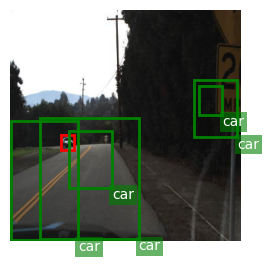

In [20]:
min_tfms = v2.Compose([
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Resize((300, 300), antialias=False),
    # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

test_data_clean = CarImageClass.ImageClass(targ_dir=test_path, transform=min_tfms, file_pct=1)
test_data = CarImageClass.ImageClass(targ_dir=test_path, transform=test_tfms, file_pct=1)

idx = np.random.randint(0, len(test_data))

testpred = ssdtestmodel.predict(test_data[idx][0].unsqueeze(dim=0).to(device), score_thresh=0.2, max_per_img=50)

pred_boxs = testpred[0]['boxes'].to('cpu')
pred_labels = ids_to_names(testpred[0]['labels'], mapping=id2name)

total_preds = 5
show_with_box(test_data_clean[idx], color='r', lw=2, label=False, pred_box=True, bbox_pred=pred_boxs[0:total_preds], label_pred=pred_labels[0:total_preds])

In [114]:
testpred[0]['scores']

[0.9171721935272217,
 0.4345936179161072,
 0.42186182737350464,
 0.38467440009117126,
 0.34503477811813354,
 0.30761319398880005]